In [4]:
import numpy as np
import pandas as pd
from scipy import sparse, special, stats

# Perceptual Simulation
import scipy.stats as stats

# We set the hit rate to 0.75 and assume Clockwise is the signal (1:CW, 0:CCW)
Goal_Hit_Prob = 0.75
signal_mean = 1 
noise_mean = 0
criterion = 0.5 # we assume the criterion is 0.5, since the two orientations are equally likely
common_std = 0.7413011092528007

## initialization 1214

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import constrNMPy
import os 
import warnings

from matplotlib import gridspec
from scipy import sparse, special, stats

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)

# color pallette
[gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']
[vio, grb, lig, sil, aqua] = ['#8c84cf','#6699CC','#66CC99','#C0C0C0','#6db3bc']
# set the style of the plots
az.style.use("arviz-white")
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

In [2]:
# The perception process is reduced to a SDT model
def Data_Gen(trialnum, 
             signal_mean = 1, noise_mean = 0, criterion = 0.5, std = 0.7413011092528007):
    '''
    Generate data with noise for a given number of trials.
    '''
    samples_1 = np.random.normal(signal_mean, std, int(trialnum/2))
    labels_1 = np.ones(int(trialnum/2))
    samples_2 = np.random.normal(noise_mean, std, int(trialnum/2))
    labels_2 = np.zeros(int(trialnum/2))
    samples = np.concatenate((samples_1, samples_2), axis=0)
    labels = np.concatenate((labels_1, labels_2), axis=0)
    # shuffle the data
    idx = np.arange(trialnum)
    np.random.shuffle(idx)
    samples = samples[idx]
    labels = labels[idx]
    likelihood_signal = stats.norm.cdf(samples, criterion, std)
    likelihood_noise = 1 - stats.norm.cdf(samples, criterion, std)
    likelihood = np.vstack((likelihood_noise,likelihood_signal))
    return samples, labels, likelihood


# Simulate the Reinforcement Learning process per trial

def RL_1_per_trial(posterior, mapping, v_L, v_R, label, learning_rate, reward = 1, punishment = -1):
    '''
    Simulate the Reinforcement Learning process per trial.
    param posterior: the posterior probability of the signal : [\  /], this model is just likelihood
    param mapping: the mapping of the response keys: [\  /] or [/  \], 1 for [\  /] and 2 for [/  \]
    param v_L, v_R: the value of the left and right action
    param label: the label of the stimulus: 1 for CW / and 0 for CCW \ 
    param learning_rate: the learning rate of the RL model
    param reward/punishment: the reward and punishment value for the correct response
    
    Return: 
    action: the action chosen by the model, -1 for left and 1 for right
    resp_ori: the orientation of the response, 1 for CW / and 0 for CCW \ 
    feedback: the feedback given by the environment, 1 for correct and 0 for incorrect
    v_L, v_R: the updated value of the left and right action
    '''
    key_mapping = {-1: [0, 1], 1: [1, 0]}
    
    if mapping == 1:
        U_L = posterior[0] * v_L
        U_R = posterior[1] * v_R
    else:
        U_L = posterior[1] * v_L
        U_R = posterior[0] * v_R
    
    # choose the action with the larger utility and receive the feedback
    action = np.sign(U_R - U_L)
    resp_ori = key_mapping[action][mapping-1]
    feedback = int(resp_ori == label)
    r = reward if feedback else punishment
    
    # update the value of the chosen action
    if action == -1:
        v_L += learning_rate * (r - v_L)
    else:
        v_R += learning_rate * (r - v_R)
    
    return action, resp_ori, feedback, v_L, v_R

# SD_calculation helper functions
def criterion(hit, FA):
    return -0.5*(stats.norm.ppf(hit) + stats.norm.ppf(FA))

def dprime(hit, FA):
    return (stats.norm.ppf(hit) - stats.norm.ppf(FA))/np.sqrt(2)

def hit_fa(df):
    hit = df[(df['StimSeq'] == 45)]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == -45)]['Accuracy']
    return hit, fa

def hit_fa_motor(df):
    hit = df[(df['StimSeq'] == df['ProbeOriRight'])]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == df['ProbeOriLeft'])]['Accuracy']
    return hit, fa

def process_data_percept_cb(data, back):
    """Return hits and false alarms for a specific n-back"""
    hit, fa = hit_fa(data[(data['RespOri'].shift(back) == 45) & (data['Qualified'] == True)])
    hit_n, fa_n = hit_fa(data[(data['RespOri'].shift(back) == -45) & (data['Qualified'] == True)])
    return (hit, fa, hit_n, fa_n)

def calculate_sd_nback_percept_cb(all_data):
    maxsubj = 30; maxblock = 20; maxtrial = 50; num_backs = 10
    SD_nback_Percept_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}

    for iS in range(1, maxsubj + 1):
        subject_data = all_data[iS]
        temp_data = {f"{i}_back": {"Hit": [], "FA": [], "Hit_n": [], "FA_n": []} for i in range(1, num_backs + 1)}

        for iB in range(1, maxblock + 1):
            for back in range(1, num_backs + 1):
                block_data = subject_data[iB - 1]
                hits_fa = process_data_percept_cb(block_data, back)
                temp_data[f"{back}_back"]["Hit"].append(hits_fa[0])
                temp_data[f"{back}_back"]["FA"].append(hits_fa[1])
                temp_data[f"{back}_back"]["Hit_n"].append(hits_fa[2])
                temp_data[f"{back}_back"]["FA_n"].append(hits_fa[3])

        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits = np.concatenate(temp_data[key]["Hit"])
            fas = np.concatenate(temp_data[key]["FA"])
            hits_n = np.concatenate(temp_data[key]["Hit_n"])
            fas_n = np.concatenate(temp_data[key]["FA_n"])
            cs = criterion(np.mean(hits_n), np.mean(fas_n)) - criterion(np.mean(hits), np.mean(fas))
            SD_nback_Percept_cb[key].append(cs)

    return pd.DataFrame(SD_nback_Percept_cb)


def process_data_motor_cb(data, back):
    """Return hits and false alarms for motor responses"""
    hit_L, fa_L = hit_fa_motor(data[(data['RespLorR'].shift(back) == -1) & (data['Qualified'] == True)])
    hit_R, fa_R = hit_fa_motor(data[(data['RespLorR'].shift(back) == 1) & (data['Qualified'] == True)])
    return (hit_L, fa_L, hit_R, fa_R)

def calculate_sd_nback_motor_cb(all_data):
    maxsubj = 30; maxblock = 20; num_backs = 10
    SD_nback_Motor_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}

    for iS in range(1, maxsubj + 1):
        subject_data = all_data[iS]
        temp_data = {f"{i}_back": {"Hit_L": [], "FA_L": [], "Hit_R": [], "FA_R": []} for i in range(1, num_backs + 1)}

        for iB in range(1, maxblock + 1):
            for back in range(1, num_backs + 1):
                block_data = subject_data[iB - 1]
                hits_fa = process_data_motor_cb(block_data, back)
                temp_data[f"{back}_back"]["Hit_L"].append(hits_fa[0])
                temp_data[f"{back}_back"]["FA_L"].append(hits_fa[1])
                temp_data[f"{back}_back"]["Hit_R"].append(hits_fa[2])
                temp_data[f"{back}_back"]["FA_R"].append(hits_fa[3])

        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits_L = np.concatenate(temp_data[key]["Hit_L"])
            fas_L = np.concatenate(temp_data[key]["FA_L"])
            hits_R = np.concatenate(temp_data[key]["Hit_R"])
            fas_R = np.concatenate(temp_data[key]["FA_R"])
            cs = criterion(np.mean(hits_L), np.mean(fas_L)) - criterion(np.mean(hits_R), np.mean(fas_R))
            SD_nback_Motor_cb[key].append(cs)

    return pd.DataFrame(SD_nback_Motor_cb)




In [6]:
# we run a simulation for multiple learning rates and see how it affects the SD effect

learning_rates = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1]
# learning_rates = [0.01, 2]
# prepare a matrix to store the SD effect for each learning rate, each n-back
rep_times = 50

SD_Percept_alphas = np.zeros((len(learning_rates), 10))
SD_Percept_alphas_dict = {f"a_{alpha}_rep_{i}": [] for i in range(rep_times) for alpha in learning_rates}
SD_Motor_alphas = np.zeros((len(learning_rates), 10))
SD_Motor_alphas_dict = {f"a_{alpha}_rep_{i}": [] for i in range(rep_times) for alpha in learning_rates}

##### Params Setting ########
maxsubj = 30
maxblock = 20
num_trials = 50
trial_num = 50
v_L_0 = 0.5
v_R_0 = 0.5

for irep in range(rep_times):
    if irep % 10 == 0:
        print(f"Simulation {irep} out of {rep_times}")
    
    SD_Percept_alphas_i = np.zeros((len(learning_rates), 10))
    SD_Motor_alphas_i = np.zeros((len(learning_rates), 10))
    for i, alpha in enumerate(learning_rates):
        all_subj_data = pd.DataFrame(columns=['subj', 'block', 'trial', 
                                            'stimulus', 'label', 'posterior CCW', 'posterior CW', 
                                            'action', 'resp_ori', 'feedback', 'v_L', 'v_R', 'mapping'])

        for iS in range(1, maxsubj + 1):
            for iB in range(1, maxblock + 1):
                data_samples, data_labels, posterior = Data_Gen(trial_num)
                mapping = np.random.choice([1, 2], trial_num)
                for iT in range(num_trials):
                        posterior_i = posterior[:, iT]
                        mapping_i = mapping[iT]
                        label_i = data_labels[iT]
                        data_samples_i = data_samples[iT]
                        if iT == 0:
                            v_L_i = v_L_0
                            v_R_i = v_R_0
                        else:
                            v_L_i = v_L
                            v_R_i = v_R
                        action_i, resp_ori_i, feedback_i, v_L, v_R = RL_1_per_trial(posterior_i, mapping_i, v_L_i, v_R_i, label_i, alpha)
                        temp_data = pd.DataFrame({'subj': iS, 'block': iB, 'trial': iT +1,
                                                'stimulus': data_samples_i, 'label': label_i, 'posterior CCW': posterior_i[0], 'posterior CW': posterior_i[1], 
                                                'action': action_i, 'resp_ori': resp_ori_i, 'feedback': feedback_i, 'v_L': v_L_i, 'v_R': v_R_i, 'mapping': mapping_i}, index=[iT])
                        all_subj_data = pd.concat([all_subj_data, temp_data], axis=0)

        trial_template = pd.DataFrame(columns=['StimSeq', 'RespOri', 'RespLorR', 'Accuracy', 'ProbeOriLeft', 'ProbeOriRight', 'Qualified'])
        all_data = {}
        for iS in range(1, maxsubj + 1):
            subject_data = []
            raw_subj = all_subj_data[all_subj_data['subj'] == iS]
            for iB in range(1, maxblock + 1):
                block_data = raw_subj[raw_subj['block'] == iB]
                temp_data = trial_template.copy()
                temp_data['StimSeq'] = block_data['label'].values.copy()
                temp_data['StimSeq'].replace({0: -45, 1: 45}, inplace=True)
                temp_data['RespOri'] = block_data['resp_ori'].values.copy()
                temp_data['RespOri'].replace({0: -45, 1: 45}, inplace=True)
                temp_data['RespLorR'] = block_data['action'].values.copy()
                temp_data['Accuracy'] = block_data['feedback'].values.copy()
                temp_data['ProbeOriLeft'] = block_data['mapping'].values.copy()
                temp_data['ProbeOriLeft'].replace({1: -45, 2: 45}, inplace=True)
                temp_data['ProbeOriRight'] = block_data['mapping'].values.copy()
                temp_data['ProbeOriRight'].replace({1: 45, 2: -45}, inplace=True)
                temp_data['Qualified'] = True
                subject_data.append(temp_data)
            all_data[iS] = subject_data
        
        SD_nbacks_Percept = calculate_sd_nback_percept_cb(all_data)
        SD_Percept_alphas_dict[f"a_{alpha}_rep_{irep}"] = SD_nbacks_Percept.copy()
        SD_nbacks_Motor = calculate_sd_nback_motor_cb(all_data)
        SD_Motor_alphas_dict[f"a_{alpha}_rep_{irep}"] = SD_nbacks_Motor.copy()
        SD_Percept_alphas_i[i, :] = SD_nbacks_Percept.mean(axis=0).values
        SD_Motor_alphas_i[i, :] = SD_nbacks_Motor.mean(axis=0).values
        SD_Motor_alphas[i, :] += SD_Motor_alphas_i[i, :]
        SD_Percept_alphas[i, :] += SD_Percept_alphas_i[i, :]
    
SD_Motor_alphas /= rep_times
SD_Percept_alphas /= rep_times



# Save the data
import pickle
with open('SD_RL_1_Simulation_All_Results.pickle', 'wb') as handle:
    pickle.dump([SD_Percept_alphas_dict, SD_Motor_alphas_dict], handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('SD_RL_1_Simulation_Matrices.pickle', 'wb') as handle:
    pickle.dump([SD_Percept_alphas, SD_Motor_alphas], handle, protocol=pickle.HIGHEST_PROTOCOL)


Simulation 0 out of 1


In [2]:
import pickle
with open('SD_RL_1_Simulation_All_Results.pickle', 'rb') as handle:
    [SD_Percept_alphas_dict, SD_Motor_alphas_dict] = pickle.load(handle)
with open('SD_RL_1_Simulation_Matrices.pickle', 'rb') as handle:
    [SD_Percept_alphas, SD_Motor_alphas] = pickle.load(handle)
    

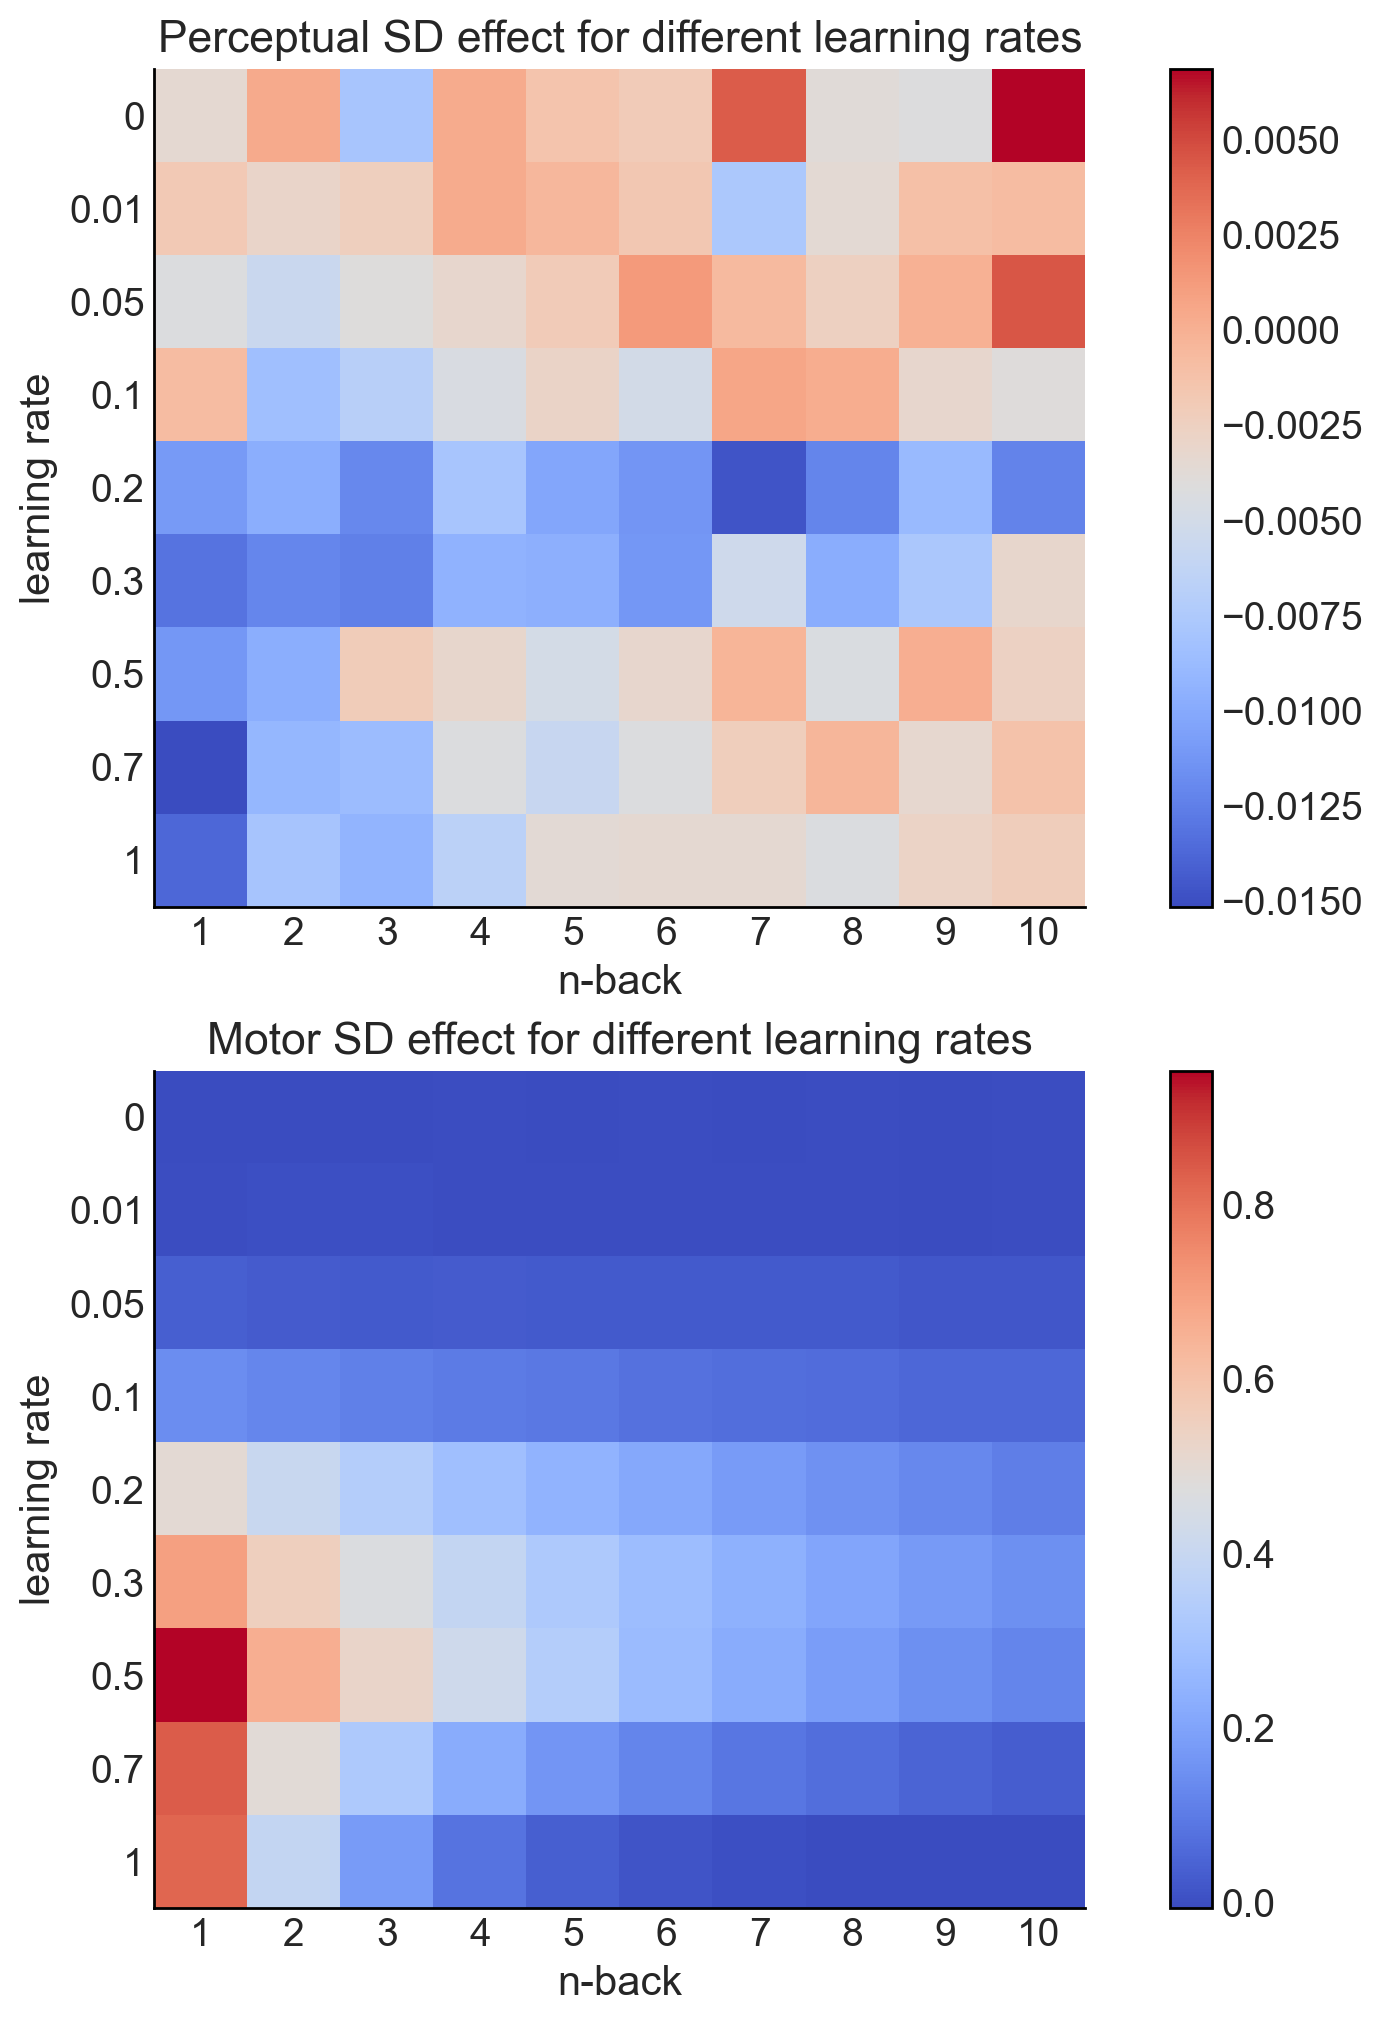

In [6]:
# visualize the SD matrix
learning_rates = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1]

fig = plt.figure(figsize=(10, 10))

plt.subplot(2,1,1)
plt.imshow(SD_Percept_alphas, cmap='coolwarm')
plt.colorbar()
plt.xlabel('n-back')
plt.ylabel('learning rate')
plt.xticks(range(10), range(1, 11))
plt.yticks(range(len(learning_rates)), learning_rates)
plt.title('Perceptual SD effect for different learning rates')

plt.subplot(2,1,2)
plt.imshow(SD_Motor_alphas, cmap='coolwarm')
plt.colorbar()
plt.xlabel('n-back')
plt.ylabel('learning rate')
plt.xticks(range(10), range(1, 11))
plt.yticks(range(len(learning_rates)), learning_rates)
plt.title('Motor SD effect for different learning rates')
plt.show()

